In [1]:
%matplotlib inline
import pandas as pd
import nivapy3 as nivapy
import matplotlib.pyplot as plt
import seaborn as sn

plt.style.use("ggplot")

In [2]:
# Connect to Nivabase
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# Compare 1000 Lakes data in RESA and Aquamonitor

## 1. Stations

The 1000 Lakes survey has project ID 12433 in AM. The aim here is to compare values in RESA and AM for all samples and parameters at these sites from the beginning of August 2019 to the end of the year.

In [3]:
# Get stations from AM
am_stns = nivapy.da.select_ndb_project_stations([12433], eng, drop_dups=True)
am_stns.rename({"station_id": "am_id"}, inplace=True, axis=1)

# Get RESA IDs for AM stations
bind_stns = ",".join("(1, %d)" % i for i in am_stns["am_id"].unique())
sql = (
    "SELECT station_id as am_id, "
    "  local_pk as resa_id "
    " FROM nivadatabase.datasource_station "
    "WHERE datasource_id = 11 "
    "AND (1, station_id) in (%s)" % bind_stns
)
stn_link = pd.read_sql(sql, eng)

# Join
stn_df = pd.merge(am_stns, stn_link, how="left", on="am_id")

print(len(stn_df), "stations in the project")

stn_df.head()

1003 stations in the project


,am_id,station_code,station_name,station_type,longitude,latitude,resa_id
0,26070,221-1-2,Langtjern,Innsjø,11.850274,59.808643,10
1,26071,101-2-7,Hokksjøen,Innsjø,11.563586,59.004423,9
2,26072,402-2-13,Sætertjern,Innsjø,12.446711,60.060222,11
3,26073,419-1-25,Mjøgsjøen,Innsjø,11.842186,60.328578,12
4,26074,425-2-2,Kottern,Innsjø,12.517008,60.590729,13


## 2. Parameters

In [4]:
# Time period of interest
st_dt = "2019-08-01"
end_dt = "2019-12-31"

# Get available parameters
print("Aquamonitor:")
am_pars = nivapy.da.select_ndb_station_parameters(
    stn_df["am_id"].unique(), st_dt, end_dt, eng
)
print("\nRESA:")
re_pars = nivapy.da.select_resa_station_parameters(
    stn_df["resa_id"].unique(), st_dt, end_dt, eng
)

# Read par-unit mapping (AM => RESA)
par_link = pd.read_csv(r"../../../resa_am_par_mapping_1k_lakes.csv", sep=";")

# Append RESA par names to AM data
am_pars = pd.merge(
    par_link, am_pars, how="left", left_on="am_par_id", right_on="parameter_id"
)

print()
print(len(am_pars), "matched parameters in total.")

Aquamonitor:
39 parameters available for the selected stations and dates.

RESA:
36 parameters available for the selected stations and dates.

36 matched parameters in total.


## 3. Water chemistry

In [5]:
# Get water chemistry
am_wc, am_dups = nivapy.da.select_ndb_water_chemistry(
    stn_df["am_id"].unique(), am_pars, st_dt, end_dt, eng, drop_dups=True
)
re_wc, re_dups = nivapy.da.select_resa_water_chemistry(
    stn_df["resa_id"].unique(), re_pars, st_dt, end_dt, eng, drop_dups=True
)

# Rename AM to RESA
am_pars["am_name"] = am_pars["parameter_name"] + "_" + am_pars["unit"]
am_pars["resa_name"] = am_pars["resa_par_name"] + "_" + am_pars["resa_unit"]
rename_dict = dict(zip(am_pars["am_name"], am_pars["resa_name"]))
am_wc.rename(rename_dict, inplace=True, axis=1)

# Convert AM units to RESA
for col in am_wc.columns:
    par = col.split("_")[0]
    if par in par_link["resa_par_name"].values:
        factor = par_link.query("resa_par_name == @par")["am_resa_factor"].iloc[0]
        am_wc[col] = am_wc[col] * factor

WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



In [6]:
# Show duplicates from RESA
re_dups

,station_id,station_code,station_name,sample_date,depth1,depth2,parameter_name,unit,flag1,value,entered_date
26398,10,221-1-2,Langtjern,2019-10-25,0,0,TOTN,µg/l N,None,250.0,2019-12-10 09:30:02
26421,10,221-1-2,Langtjern,2019-10-25,0,0,TOTN,µg/l N,None,370.0,2020-05-12 13:30:02
26432,11,402-2-13,Sætertjern,2019-10-25,0,0,TOTN,µg/l N,None,260.0,2019-11-28 10:30:02
26455,11,402-2-13,Sætertjern,2019-10-25,0,0,TOTN,µg/l N,None,400.0,2020-05-08 10:30:02
25197,14,432-1-26,Måsabutjørna,2019-10-24,0,0,TOTN,µg/l N,None,83.0,2020-03-03 16:30:05
...,...,...,...,...,...,...,...,...,...,...,...
30619,18073,929-605,Måvatn,2019-10-29,0,0,TOTN,µg/l N,None,380.0,2020-05-14 10:30:03
32550,18242,1037-19,Fjotlandsvatnet,2019-10-30,0,0,TOTN,µg/l N,None,340.0,2020-01-07 16:30:02
32573,18242,1037-19,Fjotlandsvatnet,2019-10-30,0,0,TOTN,µg/l N,None,410.0,2020-05-14 08:30:03
25175,38707,412-2-206,Store Ljøsvatnet,2019-10-23,0,0,TOTN,µg/l N,None,180.0,2019-12-10 10:30:02


The duplicates in RESA are mostly the TOTN reanalyses, as expected. However, there are only ~500 reanalyses here, so **where are the rest?**

In [7]:
# Restructure
am_wc.drop(["station_id", "station_name"], inplace=True, axis=1)
re_wc.drop(["station_id", "station_name"], inplace=True, axis=1)

am_wc = am_wc.melt(
    id_vars=["station_code", "sample_date", "depth1", "depth2"], value_name="am_value"
)
re_wc = re_wc.melt(
    id_vars=["station_code", "sample_date", "depth1", "depth2"], value_name="resa_value"
)

wc_df = pd.merge(
    am_wc,
    re_wc,
    how="inner",
    on=["station_code", "sample_date", "depth1", "depth2", "variable"],
)

wc_df

,station_code,sample_date,depth1,depth2,variable,am_value,resa_value
0,221-1-2,2019-10-25,0,0,Al/Il_µg/l,130.00,130.00
1,101-2-7,2019-10-25,0,0,Al/Il_µg/l,220.00,220.00
2,402-2-13,2019-10-25,0,0,Al/Il_µg/l,130.00,130.00
3,419-1-25,2019-10-25,0,0,Al/Il_µg/l,120.00,120.00
4,425-2-2,2019-10-25,0,0,Al/Il_µg/l,120.00,120.00
...,...,...,...,...,...,...,...
37687,1001-2-204,2019-10-28,0,0,pH_,NaN,NaN
37688,1001-2-204,2019-10-29,0,0,pH_,6.34,6.34
37689,412-2-206,2019-10-07,0,0,pH_,NaN,NaN
37690,412-2-206,2019-10-23,0,0,pH_,6.43,6.43


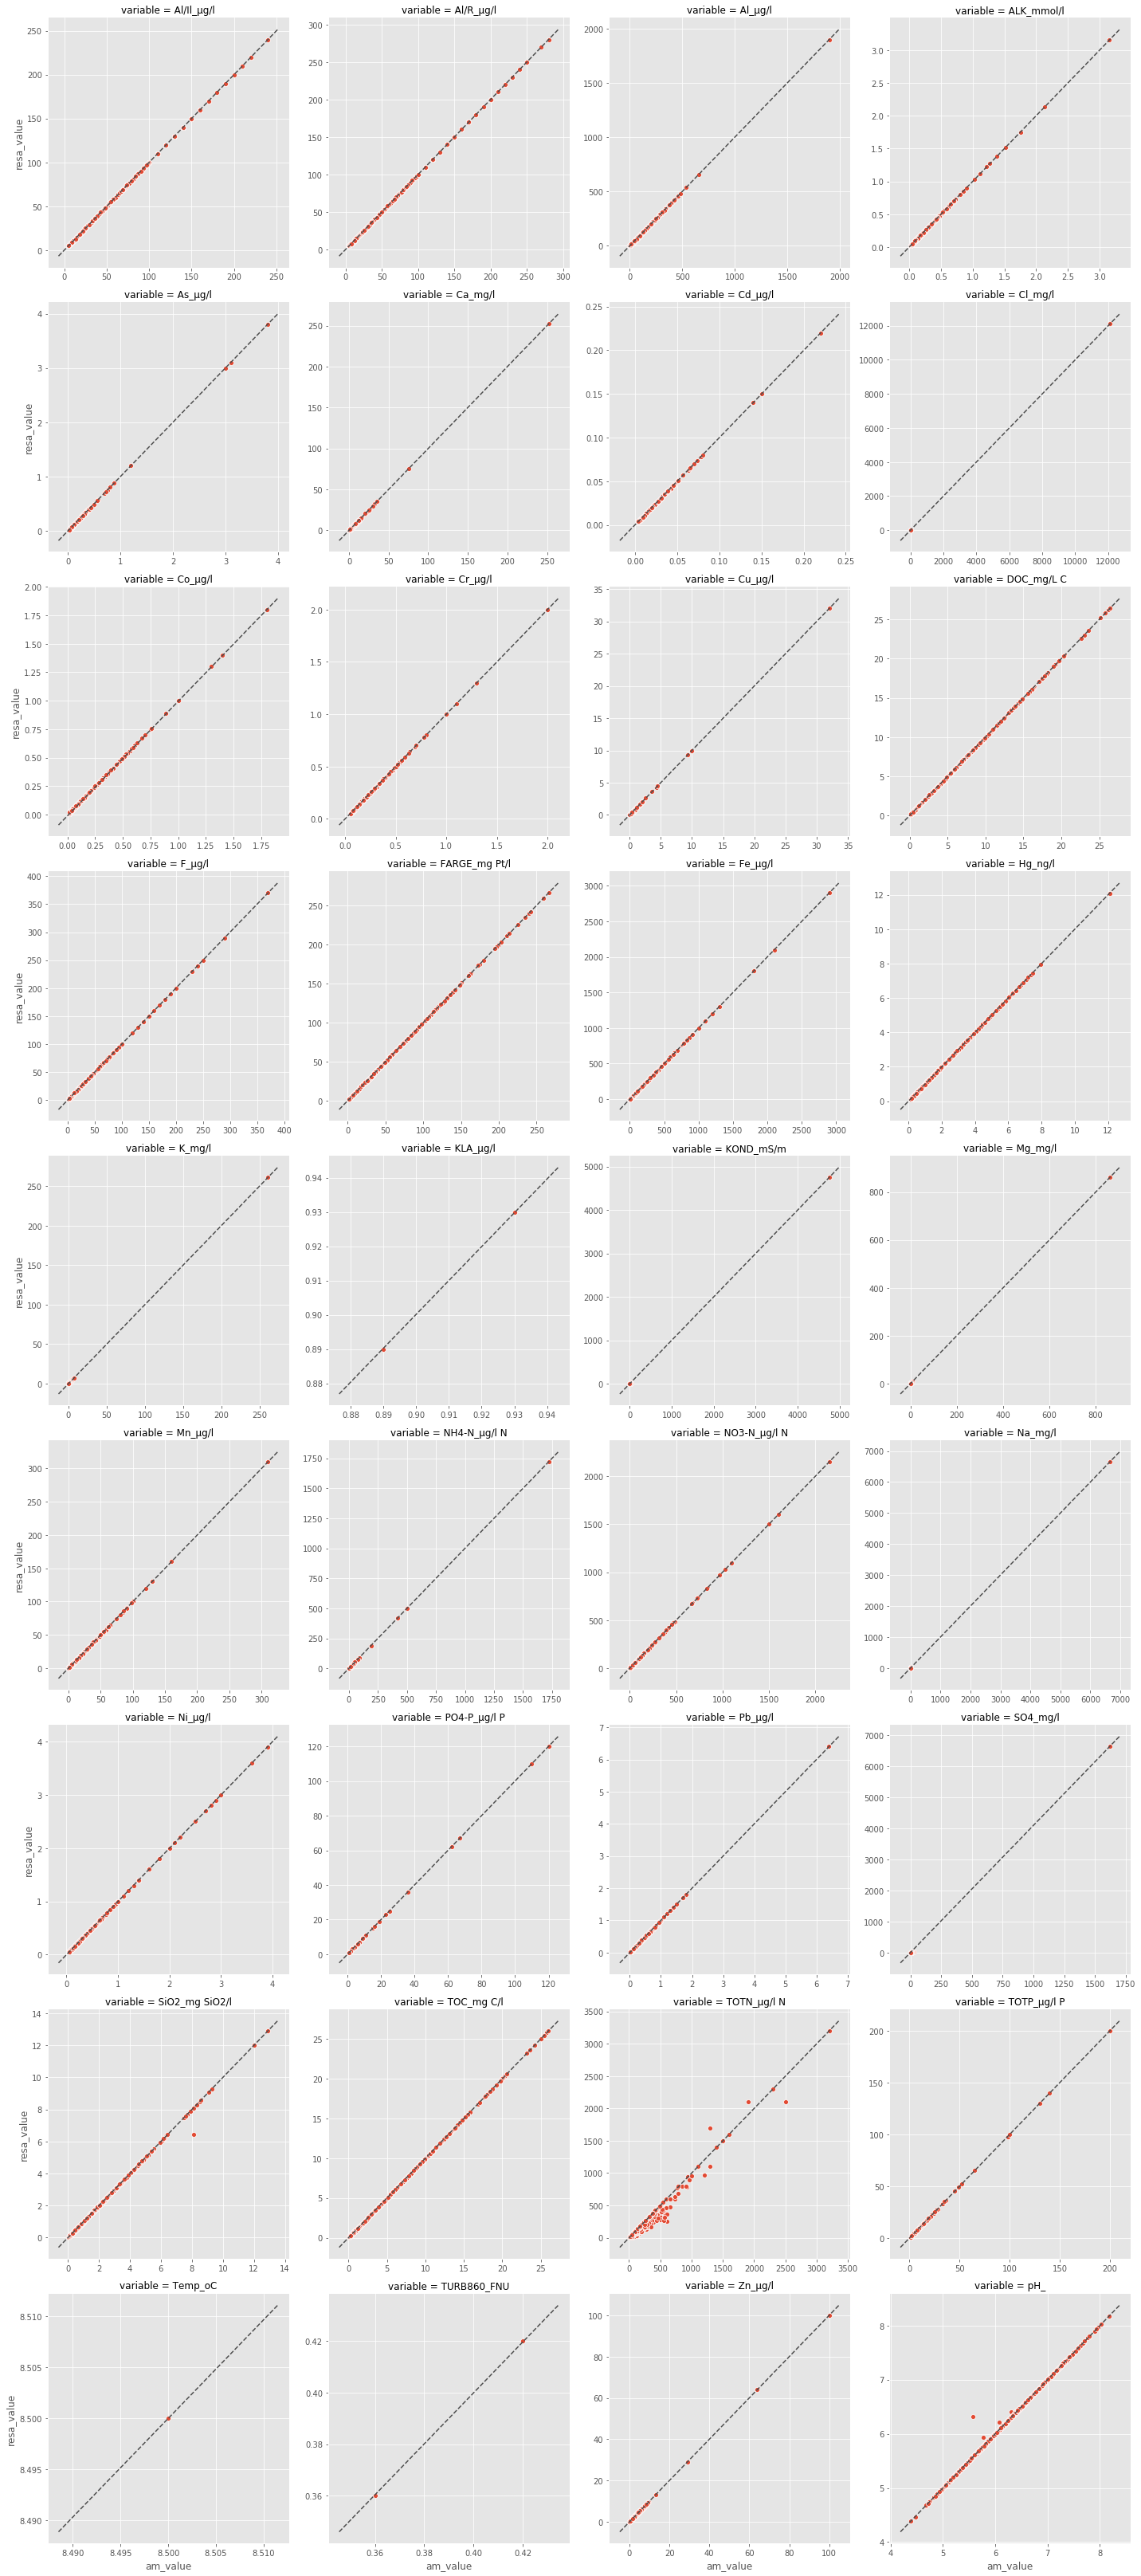

In [13]:
# Compare RESA to AM
g = sn.relplot(
    data=wc_df,
    x="am_value",
    y="resa_value",
    col="variable",
    col_wrap=4,
    facet_kws={"sharey": False, "sharex": False},
)

for ax in g.axes:
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    
plt.savefig(r'../output/compare_resa_am.png', dpi=200)

In [12]:
df = wc_df.query('variable == "TOTN_µg/l N"')
print(
    "The number of matching TOTN values in RESA and AM is",
    (df["am_value"] == df["resa_value"]).sum(),
)

The number of matching TOTN values in RESA and AM is 521
